In [7]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import pickle
import time

In [2]:
REBUILD_DATA = True

class DogsVSCats():
    img_size = 50
    cats = "C:/Users/user/Downloads/Timmtet/Projects/Deep learning/CNN/kagglecatsanddogs_5340/PetImages/Cat"
    dogs = "C:/Users/user/Downloads/Timmtet/Projects/Deep learning/CNN/kagglecatsanddogs_5340/PetImages/Dog"
    labels = {cats : 0, dogs:1}
    training_data = []
    cat_count = 0
    dog_count = 0
    
    
    def making_training_data(self):
        for label in self.labels:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label,f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.img_size, self.img_size))
                    self.training_data.append([np.array(img), np.eye(2)[self.labels[label]]])
                    #self.training_data.append([np.array(img), self.labels[label]])

                    if label == self.cats:
                        self.cat_count +=1
                    elif label == self.dogs:
                        self.dog_count +=1
                        
                except Exception as e:
                    pass
                
        np.random.shuffle(self.training_data)
        #np.save("training_data.npy", self.training_data)
        with open("training_data.pkl", "wb") as f:
            pickle.dump(self.training_data, f)
        
        print("Cats: ", self.cat_count)
        print("Dogs: ", self.dog_count)
        
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.making_training_data()

C:/Users/user/Downloads/Timmtet/Projects/Deep learning/CNN/kagglecatsanddogs_5340/PetImages/Cat


100%|████████████████████████████████████████████████████████████████████████████| 12501/12501 [02:36<00:00, 79.96it/s]


C:/Users/user/Downloads/Timmtet/Projects/Deep learning/CNN/kagglecatsanddogs_5340/PetImages/Dog


100%|████████████████████████████████████████████████████████████████████████████| 12501/12501 [02:33<00:00, 81.35it/s]


Cats:  12476
Dogs:  12470


Now we run this script to determine the input size for the dense/linear layer

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #(input, output, cornel size(5*5))
        self.conv1 = nn.Conv2d(1,32, 5)
        self.conv2 = nn.Conv2d(32,64, 5)
        self.conv3 = nn.Conv2d(64,128, 5)
        
        
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512,2)
        
    def convs(self, x):
        #(2,2) is the shape of the max pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        
        # This print statement will give us the shape of input for the dense/linear layer
        print(x[0].shape)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        
        return x
    
    def forward(self,x):
        x = self.convs(x)                  # we pass x through all the convolutional layers
        x =x.view(-1, self._to_linear )    # we flatten the output of the convolution layer. self._to_linear is the input shape of
                                            # of the linear layer we are trying to linear year.
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.softmax(x, dim=1)
             
net = Net() 
    
        
        
        

torch.Size([128, 2, 2])


Niw we will re-run the script with the exact |imput size

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #(input, output, cornel size(5*5))
        self.conv1 = nn.Conv2d(1,32, 5)
        self.conv2 = nn.Conv2d(32,64, 5)
        self.conv3 = nn.Conv2d(64,128, 5)
        
        self.fc1 = nn.Linear(2*2*128, 512)
        self.fc2 = nn.Linear(512,2)
        
    def convs(self, x):
        #(2,2) is the shape of the max pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        return x
    
    def forward(self,x):
        x = self.convs(x)                  
        x =x.view(-1,2*2*128)   
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.softmax(x, dim=1)
             
net = Net() 
    
        
        
        

In [6]:
training_data = np.load("training_data.pkl", allow_pickle=True)

import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)

loss_function = nn.MSELoss()

X  = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/225.0

y  = torch.Tensor([i[1] for i in training_data])


VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

C:\Users\user\AppData\Local\Temp\ipykernel_15176\3472780919.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  X  = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)


2494


In [9]:
train_x = X[:-val_size]
train_y = y[:-val_size]

test_x = X[-val_size:]
test_y = y[-val_size:]

print(len(train_x))
print(len(train_y))
print(len(test_x))
print(len(test_y))

22452
22452
2494
2494


In [11]:
if torch.cuda.is_available(): 
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the CPU


In [12]:
def fwd_pass(X, y, train = False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)
    
    if train:
        loss.backward()
        optimizer.step()
        
    return acc, loss



def test(size =32):
    random_start = np.random.randint(len(test_x)-size)
    X, y = test_x[random_start:random_start+size], test_y[random_start:random_start+size]
    with torch.no_grad():
        val_acc, val_loss = fwd_pass(X.view(-1,1,50,50).to(device), y.to(device))
    return  val_acc, val_loss

val_acc, val_loss = test(size = 32)
print(val_acc, val_loss)
    

0.65625 tensor(0.2485)


In [13]:
import time

Model_name = f'model-{int(time.time())}'

net = Net().to(device)

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print(Model_name)

train_losses = []
val_losses = []

def train():
    BATCH_SIZE = 100
    EPOCHS = 10
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_x), BATCH_SIZE)):
            batch_x = train_x[i:i+BATCH_SIZE].view(-1,1,50,50).to(device)
            batch_y = train_y[i:i+BATCH_SIZE].to(device)

            acc, loss = fwd_pass(batch_x, batch_y, train =True)
            if i % 50 == 0:
                val_acc, val_loss = test(size=100)
                
        train_losses.append(loss)
        val_losses.append(val_loss)
        
        print(f"Epoch: {epoch+1}, "
                      f"Training Accuracy: {round(float(acc), 2)}, "
                      f"Training Loss: {round(float(loss), 2)}, "
                      f"Testing Accuracy: {round(float(val_acc), 2)}, "
                      f"Testing Loss: {round(float(val_loss), 2)}\n")


train()


model-1693518351


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [03:23<00:00,  1.11it/s]


Epoch: 1, Training Accuracy: 0.71, Training Loss: 0.22, Testing Accuracy: 0.6, Testing Loss: 0.23



100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [03:32<00:00,  1.06it/s]


Epoch: 2, Training Accuracy: 0.79, Training Loss: 0.16, Testing Accuracy: 0.77, Testing Loss: 0.17



100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [03:55<00:00,  1.04s/it]


Epoch: 3, Training Accuracy: 0.9, Training Loss: 0.11, Testing Accuracy: 0.77, Testing Loss: 0.16



100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [03:47<00:00,  1.01s/it]


Epoch: 4, Training Accuracy: 0.88, Training Loss: 0.09, Testing Accuracy: 0.78, Testing Loss: 0.16



100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [04:35<00:00,  1.22s/it]


Epoch: 5, Training Accuracy: 0.9, Training Loss: 0.08, Testing Accuracy: 0.82, Testing Loss: 0.13



100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [03:59<00:00,  1.07s/it]


Epoch: 6, Training Accuracy: 0.92, Training Loss: 0.07, Testing Accuracy: 0.8, Testing Loss: 0.14



100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [03:34<00:00,  1.05it/s]


Epoch: 7, Training Accuracy: 0.88, Training Loss: 0.06, Testing Accuracy: 0.72, Testing Loss: 0.19



100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [03:32<00:00,  1.06it/s]


Epoch: 8, Training Accuracy: 0.92, Training Loss: 0.06, Testing Accuracy: 0.78, Testing Loss: 0.16



100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [03:38<00:00,  1.03it/s]


Epoch: 9, Training Accuracy: 0.92, Training Loss: 0.04, Testing Accuracy: 0.74, Testing Loss: 0.19



100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [03:36<00:00,  1.04it/s]

Epoch: 10, Training Accuracy: 0.96, Training Loss: 0.05, Testing Accuracy: 0.67, Testing Loss: 0.26



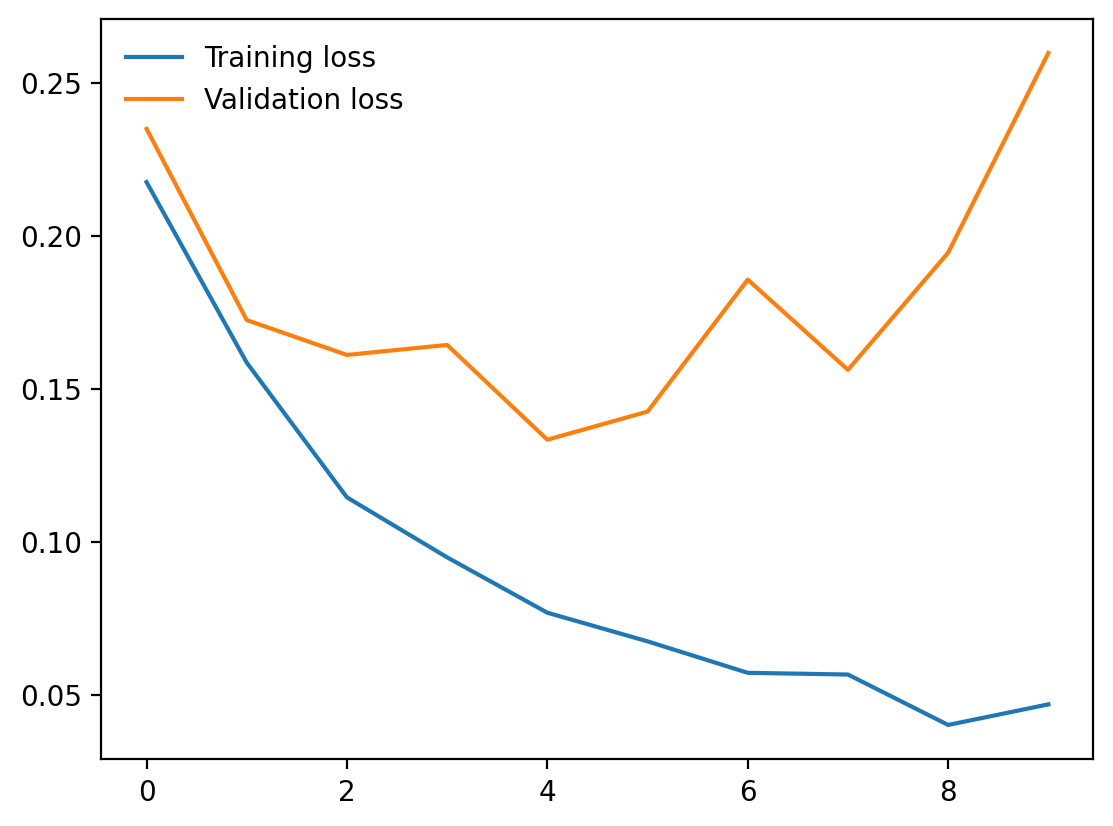

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

# Convert tensors to NumPy arrays using detach()
training_loss = [float(loss_item.detach()) for loss_item in train_losses]
validation_loss = [float(val_loss_item.detach()) for val_loss_item in val_losses]


plt.plot(training_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.legend(frameon=False)